<a href="https://colab.research.google.com/github/fosfrancesco/pitch-spelling/blob/main/rnncrf_pitch_spelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install --upgrade pytorch-crf

In [2]:
# from google.colab import files

import music21 as m21
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import pickle

from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn
import music21 as m21
from collections import Counter

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torch.nn.functional as F
#from torchcrf import CRF

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tqdm import tqdm, tqdm_notebook, notebook
import pickle

from sklearn.metrics import accuracy_score

import time

import kmeans1d
import jenkspy

from collections import defaultdict, Counter

from numba import njit
# import optuna

# Pitch Spelling and ks Prediction

Dataset: different authors from ASAP collection
Challenges:
- extremely long sequences
- small dataset

In [3]:
pitches_dict = {
    0 : ["C","B#","D--"], # nn.Linear(input_size+context_size, 3)
    1 : ["C#","B##","D-"], # nn.Linear(input_size+context_size, 2)
    2 : ["D","C##","E--"], # nn.Linear(input_size+context_size, 3)
    3 : ["D#","E-","F--"],
    4 : ["E","D##","F-"],
    5 : ["F","E#","G--"],
    6 : ["F#","E##","G-"],
    7 : ["G","F##","A--"],
    8 : ["G#","A-"],
    9 : ["A","G##","B--"],
    10 : ["A#","B-","C--"],
    11 : ["B","A##","C-"]
}

accepted_pitches = [ii for i in pitches_dict.values() for ii in i]
print([e for e in enumerate(accepted_pitches)])

double_acc_pitches = [ii for i in pitches_dict.values() for ii in i if ii.endswith("##") or  ii.endswith("--") ]
print(double_acc_pitches)

def score2midi_numbers(score):
    return [p.midi%12 for n in score.flat.notes for p in n.pitches]

def score2pitches(score):
    return [p.name for n in score.flat.notes for p in n.pitches]

interval_dict = {
    0 : ["P1","d2","A7"], 
    1 : ["m2","A1"], 
    2 : ["M2","d3","AA1"], 
    3 : ["m3","A2"],
    4 : ["M3","d4","AA2"],
    5 : ["P4","A3"],
    6 : ["d5","A4"],
    7 : ["P5","d6","AA4"],
    8 : ["m6","A5"],
    9 : ["M6","d7","AA5"],
    10 : ["m7","A6"],
    11 : ["M7","d1","AA6"]
}

accepted_intervals = [ii for i in interval_dict.values() for ii in i]
print([e for e in enumerate(accepted_intervals)])

def transp_score(score):
    """ For each input return len(accepted_intervals) transposed scores"""
    return [score.transpose(interval) for interval in accepted_intervals]

def smart_transp_score(score):
    """ For each chromatic interval chose the interval that lead to the smallest number of accidentals"""
    scores = []
    for chromatic_int in interval_dict.keys():
        temp_scores = []
        temp_acc_number = []
        for diat_interval in interval_dict[chromatic_int]:
            new_score = score.transpose(diat_interval)
            temp_scores.append(new_score)
            temp_acc_number.append(sum([pitch.count("#") + pitch.count("-") for pitch in score2pitches(new_score)]))
            # print("choice:", [note.name for note in temp_scores[-1].flat.notes][0:10],"acc:",temp_acc_number[-1] )
        #keep only the one with the lowest number of accidentals
        min_index = np.argmin(temp_acc_number)
        # print("preferred the number", min_index)
        scores.append(temp_scores[min_index])
    return scores

def acc_simple_enough(score,accepted_ratio = 0.2 ):
    pitches = score2pitches(score)
    double_acc = sum(el in double_acc_pitches for el in pitches)
    if double_acc/len(pitches) < accepted_ratio:
        return True
    else:
        return False

diatonic_pitches = ["C","D", "E", "F", "G", "A", "B"]

accepted_ks = list(range(-7,8))

print(accepted_ks)

# #test acc_simple_enough()
# score = m21.converter.parse(paths[356])
# scores = smart_transp_score(score)
# #delete the pieces with non accepted pitches (e.g. triple sharps)
# scores = [s for s in scores if all(pitch in accepted_pitches for pitch in score2pitches(s))]
# for s in scores:
#     print(s.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0], "simple enough:", acc_simple_enough(s))
#     print([n.name for n in s.flat.notes])

[(0, 'C'), (1, 'B#'), (2, 'D--'), (3, 'C#'), (4, 'B##'), (5, 'D-'), (6, 'D'), (7, 'C##'), (8, 'E--'), (9, 'D#'), (10, 'E-'), (11, 'F--'), (12, 'E'), (13, 'D##'), (14, 'F-'), (15, 'F'), (16, 'E#'), (17, 'G--'), (18, 'F#'), (19, 'E##'), (20, 'G-'), (21, 'G'), (22, 'F##'), (23, 'A--'), (24, 'G#'), (25, 'A-'), (26, 'A'), (27, 'G##'), (28, 'B--'), (29, 'A#'), (30, 'B-'), (31, 'C--'), (32, 'B'), (33, 'A##'), (34, 'C-')]
['D--', 'B##', 'C##', 'E--', 'F--', 'D##', 'G--', 'E##', 'F##', 'A--', 'G##', 'B--', 'C--', 'A##']
[(0, 'P1'), (1, 'd2'), (2, 'A7'), (3, 'm2'), (4, 'A1'), (5, 'M2'), (6, 'd3'), (7, 'AA1'), (8, 'm3'), (9, 'A2'), (10, 'M3'), (11, 'd4'), (12, 'AA2'), (13, 'P4'), (14, 'A3'), (15, 'd5'), (16, 'A4'), (17, 'P5'), (18, 'd6'), (19, 'AA4'), (20, 'm6'), (21, 'A5'), (22, 'M6'), (23, 'd7'), (24, 'AA5'), (25, 'm7'), (26, 'A6'), (27, 'M7'), (28, 'd1'), (29, 'AA6')]
[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


## Import ASAP dataset

In [4]:
# !git clone https://github.com/fosfrancesco/pitch-spelling.git

basepath = "./" #to change if running locally or on colab

In [5]:
# load the asap datasets with ks
with open(Path('./asapks.pkl'), 'rb') as fid:
     full_dict_dataset = pickle.load( fid)

        
######## Note for Nicolas: I called it "dict_dataset", but it is a list of dictionaries

In [6]:
paths = list(set([e["original_path"] for e in full_dict_dataset ]))

# print(paths)
print(len(paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_dict_dataset ]))


222 different pieces
Average number of notes:  2410.253424657534


## Chose the convenient data augmentation
For each chromatic interval, take only the diatonic transposition that produce the smallest number of accidentals (or the original if present).

Then remove the pieces with ks that have more than 7 sharps or 7 flats.

In [7]:
# choose only one enharmonic version for each chromatic interval for each piece
dict_dataset = []
for path in paths:
    for c in range(12):
        pieces_to_consider = [opus for opus in full_dict_dataset 
                              if (opus["original_path"] == path and opus["transposed_of"] in interval_dict[c])  ]
        # if the original is in pieces_to_consider, go with the original
        originals = [opus for opus in pieces_to_consider if opus["transposed_of"] == "P1"]
        if len(originals) == 1:
            dict_dataset.append(originals[0])
        else: #we go with the accidental minization criteria
            n_accidentals = [sum([pitch.count("#") + pitch.count("-") for pitch in opus["pitches"]]) 
                            for opus in pieces_to_consider]
            if len(pieces_to_consider)>0:
                dict_dataset.append(pieces_to_consider[np.argmin(n_accidentals)])
            else:
                print("No options for", path, ". Chromatic: ",c )
                
#also remove unaccepted ks
print("Before removing according to ks:", len(dict_dataset))
dict_dataset = [e for e in dict_dataset if all([k in accepted_ks for k in e["key_signatures"]])]
print("After removing according to ks:", len(dict_dataset))
                                                    

# #test if it worked
# for i,e in enumerate(dict_dataset):
#     print(e["original_path"], e["transposed_of"], e["key_signatures"])
#     print(e["pitches"][:10])
#     print(e["midi_number"][:10])
#     if i == 100:
#         break

No options for Liszt/Transcendental_Etudes/10/xml_score.musicxml . Chromatic:  1
No options for Liszt/Transcendental_Etudes/10/xml_score.musicxml . Chromatic:  6
No options for Debussy/Images_Book_1/1_Reflets_dans_lEau/xml_score.musicxml . Chromatic:  3
No options for Debussy/Images_Book_1/1_Reflets_dans_lEau/xml_score.musicxml . Chromatic:  8
No options for Ravel/Gaspard_de_la_Nuit/1_Ondine/xml_score.musicxml . Chromatic:  4
No options for Ravel/Miroirs/4_Alborada_del_gracioso/xml_score.musicxml . Chromatic:  11
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  4
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  6
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  9
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  11
No options for Liszt/Transcendental_Etudes/4/xml_score.musicxml . Chromatic:  2
No options for Liszt/Transcendental_Etudes/4/xml_score.musicxml . Chromatic:  4
No options for Liszt/Transcendental_Etud

In [8]:
print(len(dict_dataset))

c = Counter()
for p in paths:
    c[p.split("/")[0]] +=1

print(c)

2406
Counter({'Bach': 59, 'Beethoven': 57, 'Chopin': 34, 'Liszt': 16, 'Schubert': 13, 'Haydn': 11, 'Schumann': 10, 'Mozart': 6, 'Ravel': 4, 'Rachmaninoff': 4, 'Debussy': 2, 'Scriabin': 2, 'Glinka': 1, 'Prokofiev': 1, 'Brahms': 1, 'Balakirev': 1})


In [9]:
# remove pieces from asap that are in Musedata
print(len(paths), "initial pieces")
paths = [p for p in paths if p!= "Bach/Prelude/bwv_865/xml_score.musicxml"]

#remove mozart Fantasie because of incoherent key signature
paths = [p for p in paths if p!= 'Mozart/Fantasie_475/xml_score.musicxml']

print(len(paths), "pieces after removing overlapping with musedata and Mozart Fantasie")

222 initial pieces
220 pieces after removing overlapping with musedata and Mozart Fantasie


In [10]:
# Temporary remove composer with only one piece, because they create problems with sklearn stratify
one_piece_composers = ['Balakirev','Prokofiev','Brahms','Glinka', 'Debussy', 'Ravel', 'Scriabin','Liszt']
paths = [p for p in paths if p.split("/")[0] not in one_piece_composers]

# Divide train and validation set
path_train, path_validation = sklearn.model_selection.train_test_split(paths, test_size=0.15,stratify=[p.split("/")[0] for p in paths ])
print("Train and validation lenghts: ",len(path_train),len(path_validation))



Train and validation lenghts:  163 29


['Schubert', 'Haydn', 'Schumann', 'Bach', 'Mozart', 'Chopin', 'Rachmaninoff', 'Beethoven']


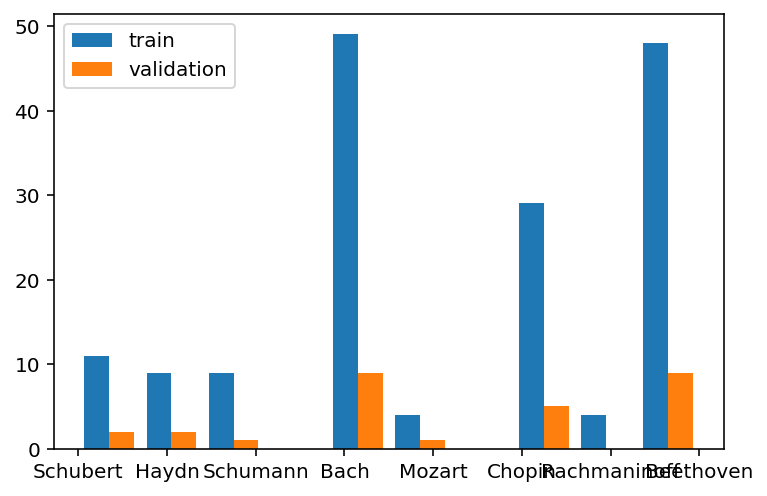

In [11]:
#need to find a better way to visualize this
composers = list(set([p.split("/")[0] for p in paths ]))
print(composers)

train_composer = [composers.index(p.split("/")[0]) for p in path_train]
val_composer = [composers.index(p.split("/")[0]) for p in path_validation]

_ = plt.hist([train_composer, val_composer], label=['train', 'validation'])
_ = plt.legend(loc='upper left')
_ = plt.xticks(list(range(len(composers))), composers)

## Transform the input into a convenient format for the Model

In [12]:
from utils import PAD
# Helper functions to feed the correct input into the NN 

N_DURATION_CLASSES = 4

pitch_to_ix = {p: accepted_pitches.index(p) for p in accepted_pitches}
ks_to_ix = {k: accepted_ks.index(k) for k in accepted_ks}
#add PADDING TAD
pitch_to_ix[PAD] = len(accepted_pitches)
ks_to_ix[PAD] = len(accepted_ks)

midi_to_ix = {m: m for m in range(12)}
#add PADDING TAD
midi_to_ix[PAD] = 12

# print(midi_to_ix[1])
# print(len(midi_to_ix))



# class Pitch2Diatonic():
#     def __call__(self, in_seq):
#         return [p for p in in_seq]

class Pitch2Int():
    def __call__(self, in_seq):
        idxs = [pitch_to_ix[w] for w in in_seq]
        return idxs
    
class Ks2Int():
    def __call__(self, in_seq):
        idxs = [ks_to_ix[w] for w in in_seq]
        return idxs

class Int2Pitch():
    def __call__(self, in_seq):
        return [accepted_pitches[i] for i in in_seq]

class OneHotEncoder():
    def __init__(self, alphabet_len):
        self.alphabet_len = alphabet_len
        
    def __call__(self, sample,weights = None):
        onehot = np.zeros([len(sample), self.alphabet_len])
        tot_chars = len(sample)
        onehot[np.arange(tot_chars), sample] = 1
        return onehot
    
class DurationOneHotEncoder():
    def __init__(self, pitch_alphabet_len, n_dur_class = 4):
        self.pitch_alphabet_len = pitch_alphabet_len
        self.dur_alphabet_len = n_dur_class
        
    def __call__(self, sample, durs):
        sample = torch.tensor(sample,dtype=torch.long)
        onehot_pitch = torch.nn.functional.one_hot(sample,self.pitch_alphabet_len)
        #compute breaks in duration list
        clusters, centroids = kmeans1d.cluster(durs, N_DURATION_CLASSES)   
        quantized_durations = torch.tensor(clusters,dtype=torch.long)
        onehot_duration = torch.nn.functional.one_hot(quantized_durations,self.dur_alphabet_len)
        return torch.cat([onehot_pitch,onehot_duration],1)
    
        
class ToTensorFloat():
    def __call__(self, sample, durs = None):
        if type(sample) is torch.Tensor:
            return sample.float()
        else:
            return torch.tensor(sample,dtype=torch.float)

class ToTensorLong():
    def __call__(self, sample):
        if type(sample) is torch.Tensor:
            return sample.long()
        else:
            return torch.tensor(sample,dtype=torch.long)
    
class MultInputCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample, durs):
        for t in self.transforms:
            sample = t(sample, durs)
        return sample


### Define the preprocessing pipeline
transform_diat = transforms.Compose([Pitch2Int(),ToTensorLong()])
transform_chrom = MultInputCompose([DurationOneHotEncoder(len(midi_to_ix),N_DURATION_CLASSES),ToTensorFloat()])
transform_key = transforms.Compose([Ks2Int(),ToTensorLong()])


print(set([ks_to_ix[ks] for piece in dict_dataset for ks in piece["key_signatures"]]))
print(ks_to_ix[PAD])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
15


In [13]:
@njit
def closestMultiple(n : int, x: int):
    if x > n: 
        return x 
    else:
        return int(x*np.ceil(n/x))
    

closestMultiple(6900,2000)

8000

In [14]:
# Create the dataset
from datasets import PSDataset

train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,transform_key,True, sort = True)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat,transform_key, False)

print(len(train_dataset),len(validation_dataset))


# test if it works
for chrom,diat,ks,seq_len in train_dataset:
    print(chrom.shape)
    print(ks.shape)
    print("Division", diat.shape[0]/65)
#     print(torch.argmax(chrom[0:30],1))
#     # print([diatonic_pitches[p.item()] for p in diat[0:30]])
#     print([accepted_pitches[p.item()] for p in diat[0:30]])
    print([p.item() for p in ks[-20:]])
    print([p for p in chrom[-10:,:]])
    print(seq_len)

 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])]
462
torch.Size([462, 17])
torch.Size([462])
Division 7.107692307692307
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.

In [20]:
def pad_collate(batch):
    (chromatic_seq, diatonic_seq,ks_seq, l) = zip(*batch)
    
    chromatic_seq_pad = pad_sequence(chromatic_seq, padding_value=midi_to_ix[PAD])
    diatonic_seq_pad = pad_sequence(diatonic_seq, padding_value=pitch_to_ix[PAD])
    ks_seq_pad = pad_sequence(ks_seq, padding_value=ks_to_ix[PAD])

    #sort the sequences by length
    seq_lengths, perm_idx = torch.Tensor(l).sort(0, descending=True)
    chromatic_seq_pad = chromatic_seq_pad[:,perm_idx,:]
    diatonic_seq_pad = diatonic_seq_pad[:,perm_idx]
    ks_seq_pad = ks_seq_pad[:,perm_idx]

    return chromatic_seq_pad, diatonic_seq_pad,ks_seq_pad, seq_lengths

data_loader = DataLoader(dataset=validation_dataset,  num_workers =1, batch_size=4, shuffle=True, collate_fn=pad_collate)

#test if it work
for batch in data_loader:
    print(batch[0].shape,batch[1].shape,batch[2].shape)
    print(batch[0])
    break

torch.Size([4219, 4, 17]) torch.Size([4219, 4]) torch.Size([4219, 4])
tensor([[[ 1.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  1.,  0.]],

        [[ 1.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  1.,  0.]],

        [[ 1.,  0.,  0.,  ...,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  1.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  0.,  1.,  0.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.]],

        [[ 0.,  0.,  0.,  ...,  0.,  1.,  0.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 

## Model Definition

In [23]:
class NystromAttention(nn.Module):
    def __init__(self, head_dim,num_head,num_landmarks):
        super().__init__()

        self.head_dim = head_dim
        self.num_head = num_head

        self.num_landmarks = num_landmarks

    def forward(self, Q, K, V, mask):
        seq_len = mask.shape[1]

        Q = Q * mask[:, None, :, None] / np.sqrt(np.sqrt(self.head_dim))
        K = K * mask[:, None, :, None] / np.sqrt(np.sqrt(self.head_dim))
        
        if self.num_landmarks == seq_len:
            attn = torch.nn.functional.softmax(torch.matmul(Q, K.transpose(-1, -2)) - 1e9 * (1 - mask[:, None, None, :]), dim = -1)
            X = torch.matmul(attn, V)
        else:
            Q_landmarks = Q.reshape(-1, self.num_head, self.num_landmarks, seq_len // self.num_landmarks, self.head_dim).mean(dim = -2)
            K_landmarks = K.reshape(-1, self.num_head, self.num_landmarks, seq_len // self.num_landmarks, self.head_dim).mean(dim = -2)

            kernel_1 = torch.nn.functional.softmax(torch.matmul(Q, K_landmarks.transpose(-1, -2)), dim = -1)
            kernel_2 = torch.nn.functional.softmax(torch.matmul(Q_landmarks, K_landmarks.transpose(-1, -2)), dim = -1)
            kernel_3 = torch.nn.functional.softmax(torch.matmul(Q_landmarks, K.transpose(-1, -2)) - 1e9 * (1 - mask[:, None, None, :]), dim = -1)
            X = torch.matmul(torch.matmul(kernel_1, self.iterative_inv(kernel_2)), torch.matmul(kernel_3, V))

        return X

    def iterative_inv(self, mat, n_iter = 6):
        I = torch.eye(mat.size(-1), device = mat.device)
        K = mat
        V = 1 / (torch.max(torch.sum(torch.abs(K), dim = -2)) * torch.max(torch.sum(torch.abs(K), dim = -1))) * K.transpose(-1, -2)
        for _ in range(n_iter):
            KV = torch.matmul(K, V)
            V = torch.matmul(0.25 * V, 13 * I - torch.matmul(KV, 15 * I - torch.matmul(KV, 7 * I - KV)))
        return V

    def extra_repr(self):
        return f'num_landmarks={self.num_landmarks}, seq_len={seq_len}'

In [24]:
class Attention(nn.Module):
    def __init__(self,dim,num_head,num_landmarks):
        """
        dim : if used after a rnn, dim is the hidden dim of the rnn
        
        """
        super().__init__()

        self.dim = dim
        self.num_head = num_head
        self.num_landmarks = num_landmarks

        self.W_q = nn.Linear(self.dim, self.num_head * self.dim)
        self.W_k = nn.Linear(self.dim, self.num_head * self.dim)
        self.W_v = nn.Linear(self.dim, self.num_head * self.dim)

        self.attn = NystromAttention(self.dim,self.num_head,self.num_landmarks)

    def forward(self,X, sentences_len):
        #transpose matrix to shape [Batch,seq_len,features]
        X = torch.transpose(X,0,1)
        # pad to multiple of self.num_landmarks (pad with value "0", should we change it?)
        padding_length = closestMultiple(X.shape[1],self.num_landmarks)- X.shape[1]
        X = F.pad(X, (0,0,0,padding_length,0,0),"constant", 0)
        # compute padding mask (1 for elements to consider, ignore 0)
        pad_mask = torch.arange(X.shape[1])[None,:] < sentences_len[:,None]
        
        Q = self.split_heads(self.W_q(X))
        K = self.split_heads(self.W_k(X))
        V = self.split_heads(self.W_v(X))
        with torch.cuda.amp.autocast(enabled = False):
            attn_out = self.attn(Q.float(), K.float(), V.float(), pad_mask.float().to(device))
        out = self.combine_heads(attn_out)
        
        #slice to the original shape
        out = out[:,:int(torch.max(sentences_len)),:]
        
        #transpose back to shape [seq_len,batch,features]
        out = torch.transpose(out,0,1)
        return out

    def combine_heads(self, X):
        X = X.transpose(1, 2)
        X = X.reshape(X.size(0), X.size(1), self.num_head * self.dim)
        return X

    def split_heads(self, X):
        X = X.reshape(X.size(0), X.size(1), self.num_head, self.dim)
        X = X.transpose(1, 2)
        return X

In [25]:
class RNNNystromAttentionTagger(nn.Module):
    """Vanilla RNN + Nystrom Attention
    """
    
    def __init__(self, input_dim, hidden_dim, pitch_to_ix,ks_to_ix, n_layers =1, num_head =1, num_landmarks =64 ):
        super(RNNNystromAttentionTagger,self).__init__()    
        
        self.n_out_pitch = len(pitch_to_ix)
        self.n_out_ks = len(ks_to_ix)
        self.hidden_dim = hidden_dim
        self.num_landmarks = num_landmarks

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer_pitch = nn.Linear(hidden_dim*num_head, self.n_out_pitch)
        self.top_layer_ks = nn.Linear(hidden_dim*num_head, self.n_out_ks)
    
        # Loss function that we will use during training.
        self.loss_pitch = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = pitch_to_ix[PAD])
        self.loss_ks = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = ks_to_ix[PAD])
        
        # attention function
        self.attention = Attention(self.hidden_dim,num_head,num_landmarks)
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
               
        # use attention
        attn_applied = self.attention(rnn_out,sentences_len)
        
        out_pitch = self.top_layer_pitch(attn_applied)
        out_ks = self.top_layer_ks(attn_applied)

        return out_pitch,out_ks
                
    def forward(self, sentences, pitches, keysignatures, sentences_len):
        # First computes the predictions, and then the loss function.
        
         # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores_pitch = scores_pitch.view(-1, self.n_out_pitch)
        scores_ks = scores_ks.view(-1, self.n_out_ks)
        pitches = pitches.view(-1)
        keysignatures = keysignatures.view(-1)
        return self.loss_pitch(scores_pitch, pitches) + self.loss_ks(scores_ks,keysignatures)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted_pitch = scores_pitch.argmax(dim=2)
        predicted_ks = scores_ks.argmax(dim=2)
        return [predicted_pitch[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)],[predicted_ks[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]

In [26]:
class RNNMultNystromAttentionTagger(nn.Module):
    """Pitch-key decoupled model + 2 Nystrom Attention (one att for pich + one att for key)
    """
    
    def __init__(self, input_dim, hidden_dim, pitch_to_ix,ks_to_ix, n_layers =1, hidden_dim2 = 24, num_head =1, num_landmarks =64 ):
        super(RNNMultNystromAttentionTagger,self).__init__()    
        
        self.n_out_pitch = len(pitch_to_ix)
        self.n_out_ks = len(ks_to_ix)
        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2
        self.num_landmarks = num_landmarks

        # RNN layer. Bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        self.rnn2 = nn.GRU(input_size=hidden_dim*num_head, hidden_size=hidden_dim2//2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer_pitch = nn.Linear(hidden_dim*num_head, self.n_out_pitch)
        self.top_layer_ks = nn.Linear(hidden_dim2*num_head, self.n_out_ks)
    
        # Loss function that we will use during training.
        self.loss_pitch = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = pitch_to_ix[PAD])
        self.loss_ks = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = ks_to_ix[PAD])
        
        # attention function
        self.attention_pitch = Attention(self.hidden_dim,num_head,num_landmarks)
        self.attention_ks = Attention(self.hidden_dim2,num_head,num_landmarks)
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
        
        # use attention pitch
        rnn_out = self.attention_pitch(rnn_out,sentences_len)

        out_pitch = self.top_layer_pitch(rnn_out)
        
        #pass the ks information into the second rnn
        rnn_out = torch.nn.utils.rnn.pack_padded_sequence(rnn_out, sentences_len)
        rnn_out, _ = self.rnn2(rnn_out)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
        
        # use attention ks
        attn_applied = self.attention_ks(rnn_out,sentences_len)
        
        out_ks = self.top_layer_ks(attn_applied)

        return out_pitch,out_ks
                
    def forward(self, sentences, pitches, keysignatures, sentences_len):
        # First computes the predictions, and then the loss function.
        
         # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores_pitch = scores_pitch.view(-1, self.n_out_pitch)
        scores_ks = scores_ks.view(-1, self.n_out_ks)
        pitches = pitches.view(-1)
        keysignatures = keysignatures.view(-1)
        return self.loss_pitch(scores_pitch, pitches) + self.loss_ks(scores_ks,keysignatures)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted_pitch = scores_pitch.argmax(dim=2)
        predicted_ks = scores_ks.argmax(dim=2)
        return [predicted_pitch[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)],[predicted_ks[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]

## Train model

In [27]:
# TODO: search over the best hyperparameters

In [26]:
def training_loop(model, optimizer, train_dataloader, val_dataloader, n_epochs):
    history = defaultdict(list)  
    for i_epoch in range(1,n_epochs +1):
        t0 = time.time()
        loss_sum = 0
        accuracy_sum = 0
        model.train()
        for seqs, pitches,keysignatures, lens in train_dataloader: #seqs, pitches, keysignatures, lens are batches
            seqs, pitches,keysignatures  = seqs.to(device), pitches.to(device),keysignatures.to(device)
            optimizer.zero_grad()
            loss = model(seqs,pitches,keysignatures,lens)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            
            with torch.no_grad():
                predicted_pitch,predicted_ks = model.predict(seqs,lens)
                for i,p in enumerate(predicted_pitch):
                    acc= accuracy_score(p,pitches[:,i][:len(p)].cpu()) #compute the accuracy without considering the padding
                    accuracy_sum += acc/len(lens) #normalize according to the number of sequences in the batch

        train_loss = loss_sum/len(train_dataloader)
        train_accuracy = accuracy_sum/len(train_dataloader) #normalize according to the number of batches
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)


        # Evaluate on the validation set
        model.eval()
        all_predicted_pitch = []
        all_predicted_ks = []
        all_pitches = []
        all_ks = []
        with torch.no_grad():
            for seqs,pitches,keysignatures, lens in val_dataloader:
                # Predict the model's output on a batch
                predicted_pitch,predicted_ks = model.predict(seqs.to(device),lens)                   
                # Update the lists that will be used to compute the accuracy
                for i,(p,k) in enumerate(zip(predicted_pitch,predicted_ks)):
                    all_predicted_pitch.append(torch.Tensor(p))
                    all_predicted_ks.append(torch.Tensor(k))
                    all_pitches.append(pitches[0:int(lens[i]),i])
                    all_ks.append(keysignatures[0:int(lens[i]),i])
                
        # Compute the overall accuracy for the validation set
        val_accuracy_pitch = accuracy_score(torch.cat(all_predicted_pitch),torch.cat(all_pitches))
        val_accuracy_ks = accuracy_score(torch.cat(all_predicted_ks),torch.cat(all_ks))
        history["val_accuracy_pitch"].append(val_accuracy_pitch)
        history["val_accuracy_ks"].append(val_accuracy_ks)

#         save the model
        torch.save(model, "./models/temp/model_temp_epoch{}.pkl".format(i_epoch))
#         files.download("model_temp_epoch{}.pkl".format(i_epoch))

    
        t1 = time.time()
        print(f'Epoch {i_epoch}: train loss = {train_loss:.4f}, train_accuracy: {train_accuracy:.4f},val_accuracy_pitch: {val_accuracy_pitch:.4f},val_accuracy_ks: {val_accuracy_ks:.4f}, time = {t1-t0:.4f}')
    return history

In [27]:
# del model
# del train_dataset
# torch.cuda.empty_cache()

In [28]:
print(len(midi_to_ix)+N_DURATION_CLASSES)

17


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

n_epochs = 30
HIDDEN_DIM = 96 #as it is implemented now, this is double the hidden_dim
LEARNING_WEIGHT = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 8
MOMENTUM = 0.9
RNN_LAYERS = 1

#ks rnn hyperparameter
HIDDEN_DIM2= 48

#attention hyperparameter
NUM_HEAD = 2
NUM_LANDMARKS = 64 #should we make this depending on the seq length for each batch? 


train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,transform_key,True,sort=True, truncate = None)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat,transform_key, False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=pad_collate)
val_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False,collate_fn=pad_collate)

# model = torch.load("./models/temp/model_temp_epoch30-to_restart.pkl")

# model = RNNTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
# model = RNNMultiTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
# model = RNNNystromAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS,num_head=NUM_HEAD,num_landmarks=NUM_LANDMARKS)
model = RNNMultNystromAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS,hidden_dim2=HIDDEN_DIM2,num_head=NUM_HEAD,num_landmarks=NUM_LANDMARKS)


model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_WEIGHT, momentum = MOMENTUM,weight_decay=WEIGHT_DECAY)

history = training_loop(model,optimizer,train_dataloader,val_dataloader, n_epochs)

# After the final evaluation, we print more detailed evaluation statistics,
plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy_pitch'])
plt.plot(history['val_accuracy_ks'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy_pitch','validation_accuracy_ks'])

Training device: cuda


In [ ]:
#find the best working model on the accuracy
max_accuracy = np.max(history['val_accuracy_pitch'])
best_epoch = np.argmax(history['val_accuracy_pitch'])
print("Best validation accuracy: ",max_accuracy, "at epoch",best_epoch)

plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy_pitch'])
plt.plot(history['val_accuracy_ks'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy_pitch','validation_accuracy_ks'])

In [ ]:
# torch.save(model, "./models/model_asap_crf200dur.pkl")
# files.download("model_asap_crf300.pkl")

### print attention

## Test on Mdata dataset

In [32]:
model = torch.load("./models/model_RNNks.pkl")

In [34]:
# load the dataset
with open(Path(basepath,'./datasets/musedata_noisy.pkl'), 'rb') as fid:
     full_mdata_dict_dataset = pickle.load( fid)
        
# add dummy ks to have the same format as asap
for e in full_mdata_dict_dataset:
    e["key_signatures"] = np.zeros(len(e["pitches"]))

In [35]:
mdata_paths = list(set([e["original_path"] for e in full_mdata_dict_dataset ]))

# # remove the symbphony No.100 from Haydn because of the enharmonic transposition
# paths.remove("datasets\\opnd\\haydndoversyms-10004m.opnd-m")

# print(paths)
print(len(mdata_paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_mdata_dict_dataset ]))

216 different pieces
Average number of notes:  907.2777777777778


In [36]:
mdata_dataset = PSDataset(full_mdata_dict_dataset,mdata_paths, transform_chrom,transform_diat,transform_key,sort=False, augment_dataset=False)
mdata_dataloader = DataLoader(mdata_dataset,  batch_size=2, shuffle=False, collate_fn=pad_collate)

In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

all_inputs = []
all_predicted_pitch = []
all_predicted_ks = []
all_pitches = []
all_ks = []
model.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for seqs, pitches,ks,lens in mdata_dataloader:
        # Move data to device
        seqs = seqs.to(device)

        # Predict the model's output on a batch.
        predicted_pitch,predicted_ks = model.predict(seqs,lens)                   
        # Update the evaluation statistics.
        for i,p in enumerate(predicted_pitch):
            all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:].cpu(),1).numpy())
            all_predicted_pitch.append(p)
            all_predicted_ks.append(predicted_ks[i])
            all_pitches.append(pitches[0:int(lens[i]),i])
            all_ks.append(ks[0:int(lens[i]),i])

Using device: cuda


In [38]:
# # Divide accuracy according to author
authors = []

for sequence in all_inputs:
#     print(sequence)
    author = [e["original_path"].split("\\")[-1][:3] for e in full_mdata_dict_dataset
              if len(e["midi_number"]) == len(sequence) and
              list(e["midi_number"]) ==list(sequence) ]
    assert len(author) == 1
    authors.append(author[0])

considered_authors = list(set(authors))
print(considered_authors)

['han', 'bac', 'cor', 'bee', 'viv', 'moz', 'tel', 'hay']


In [42]:
errors_per_author_pitch = {}
accuracy_per_author_pitch = {}
notes_per_author = {}
for ca in considered_authors:
    ca_predicted_pitch = np.concatenate([all_predicted_pitch[i] for i,a in enumerate(authors) if a == ca])
    ca_predicted_ks = np.concatenate([all_predicted_ks[i] for i,a in enumerate(authors) if a == ca])
    ca_pitches = np.concatenate([all_pitches[i] for i,a in enumerate(authors) if a == ca])
    ca_ks = np.concatenate([all_ks[i] for i,a in enumerate(authors) if a == ca])

    ca_acc_pitch = accuracy_score(ca_predicted_pitch,ca_pitches)
    
    accuracy_per_author_pitch[ca] = float(ca_acc_pitch)
    errors_per_author_pitch[ca] = int(len(ca_pitches) - sum(np.equal(ca_predicted_pitch,ca_pitches)))
    notes_per_author[ca] = len(ca_pitches)

print("Pitch Statistics----------------")
print(errors_per_author_pitch)
print(accuracy_per_author_pitch)
print(notes_per_author)
print("Total errors :", sum([e for e in errors_per_author_pitch.values()]))
print("Error rate:")
print({k:(1-accuracy_per_author_pitch[k])*100 for k in accuracy_per_author_pitch.keys() })

print("Total error rate:", sum(errors_per_author_pitch.values())/sum(notes_per_author.values())*100 )



Pitch Statistics----------------
{'han': 15, 'bac': 13, 'cor': 4, 'bee': 99, 'viv': 29, 'moz': 70, 'tel': 8, 'hay': 273}
{'han': 0.9993877551020408, 'bac': 0.9994694960212201, 'cor': 0.9998366880333156, 'bee': 0.9959580288245621, 'viv': 0.9988161815732539, 'moz': 0.9971421572630031, 'tel': 0.9996734693877551, 'hay': 0.9888525928950592}
{'han': 24500, 'bac': 24505, 'cor': 24493, 'bee': 24493, 'viv': 24497, 'moz': 24494, 'tel': 24500, 'hay': 24490}
Total errors : 511
Error rate:
{'han': 0.0612244897959191, 'bac': 0.053050397877985045, 'cor': 0.01633119666843985, 'bee': 0.40419711754379195, 'viv': 0.1183818426746086, 'moz': 0.2857842736996852, 'tel': 0.03265306122448575, 'hay': 1.1147407104940776}
Total error rate: 0.2607515359337048


### BEst accuracy with ks
n_epochs = 30
HIDDEN_DIM = 96
LEARNING_WEIGHT = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 8
MOMENTUM = 0.9
RNN_LAYERS = 1

model = RNNMultiTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)

Model available in: ""./models/model_RNNks.pkl""
accuracy on validation set 0.9424
Trained on all asap dataset

{'cor': 4, 'viv': 29, 'moz': 70, 'bac': 13, 'han': 15, 'bee': 99, 'hay': 273, 'tel': 8}
{'cor': 0.9998366880333156, 'viv': 0.9988161815732539, 'moz': 0.9971421572630031, 'bac': 0.9994694960212201, 'han': 0.9993877551020408, 'bee': 0.9959580288245621, 'hay': 0.9888525928950592, 'tel': 0.9996734693877551}
{'cor': 24493, 'viv': 24497, 'moz': 24494, 'bac': 24505, 'han': 24500, 'bee': 24493, 'hay': 24490, 'tel': 24500}
Total errors : 511


Epoch 22: train loss = 0.4723, train_accuracy: 0.9533,val_accuracy_pitch: 0.9424,val_accuracy_ks: 0.7938, time = 106.7093

